In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
import itertools

import pickle
from google.colab import files

In [4]:

class signSGD(optim.Optimizer):

    def __init__(self, params, lr=0.01, rand_zero=True):
        defaults = dict(lr=lr)
        self.rand_zero = rand_zero
        super(signSGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # take sign of gradient
                grad = torch.sign(p.grad)

                # randomise zero gradients to ±1
                if self.rand_zero:
                    grad[grad==0] = torch.randint_like(grad[grad==0], low=0, high=2)*2 - 1
                    assert not (grad==0).any()
                
                # make update
                p.data -= group['lr'] * grad

        return loss

In [ ]:
class signNum(optim.Optimizer):

    def __init__(self, params, lr=0.01,momentum=0.9,weight_decay =  rand_zero=True):
        defaults = dict(lr=lr)
        self.rand_zero = rand_zero
        super(signSGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # take sign of gradient
                grad = torch.sign(p.grad)

                # randomise zero gradients to ±1
                if self.rand_zero:
                    grad[grad==0] = torch.randint_like(grad[grad==0], low=0, high=2)*2 - 1
                    assert not (grad==0).any()
                
                # make update
                p.data -= group['lr'] * grad

        return loss

In [3]:

"""Contain our own optimizer class for Signum algorithm.
References
----------
.. [1] Jeremy Bernstein, Yu-Xiang Wang, Kamyar Azizzadenesheli and Anima Anandkumar.
    *SignSGD: Compressed Optimisation for Non-Convex Problems*. (Available at:
    https://arxiv.org/abs/1802.04434)
"""


from typing import Callable, Iterable, List, Optional

import torch
import torch.distributed as dist
from torch.optim import Optimizer
from torch._utils import _flatten_dense_tensors, _unflatten_dense_tensors


class Signum(Optimizer):
    """Extend the base `torch.optim.Optimizer` class from PyTorch to the Signum algorithm."""

    def __init__(self, params: Iterable, blind_list: Optional[List[int]] = None,
                 byz_list: Optional[List[int]] = None, lr: float = 1e-4, momentum: float = 0.9,
                 weight_decay: float = 0.0):
        r"""Initialize an instance of Signum optimizer.
        Parameters
        ----------
        params : iterable
            Model parameters.
        blind_list : list of int, optional
            Ranks of blind adversaries inverting their gradients signs.
        byz_list : list of int, optional
            Ranks of Byzantine adversaries.
        lr : float, default=0.0001
            Learning rate, denoted \(\eta\) in the algorithm description.
        momentum : float, default=0.9
            Value of momentum, denoted \(\beta\) in the algorithm description. If **momentum** is
            equal to zero, yields *SignSGD*.
        weight_decay : float, default=0.0
            Value of the weight decay, denoted \(\lambda\) in the algorithm description.
        """
        if lr < 0.:
            raise ValueError(f"Invalid learning rate: {lr}")
        if momentum < 0. or momentum > 1.:
            raise ValueError(f"Invalid momentum parameter: {momentum}")
        if weight_decay < 0.:
            raise ValueError(f"Invalid weight decay value: {weight_decay}")

        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)

        super().__init__(params, defaults)

        # Handling of blind adversaries
        self.blind_list = blind_list
        self.blind_size = len(blind_list) if blind_list is not None else 0

        # Handling of Byzantine adversaries
        self.byz_list = byz_list
        self.byz_size = len(byz_list) if byz_list is not None else 0

        self.groups = []  # sharing of data between the Byzantine server and other processes
        self.byz_server = None

        if self.byz_list is not None and self.byz_size > 0:

            self.byz_server = self.byz_list[0]

            for i in range(dist.get_world_size()):

                if i != self.byz_server:
                    self.groups.append(dist.new_group([i, self.byz_server]))
                else:
                    self.groups.append(None)  # make sure we have the correct length

    def get_blind_size(self) -> int:
        """Return the number of blind adversaries inverting their gradient signs.
        Returns
        -------
        blind_size : int
            Number of blind adversaries inverting their gradient signs.
        """
        blind_size = self.blind_size

        return blind_size

    def get_byz_size(self) -> int:
        """Return the number of Byzantine adversaries.
        Returns
        -------
        byz_size : int
            Number of Byzantine adversaries.
        """
        byz_size = self.byz_size

        return byz_size

    def step(self, closure: Optional[Callable] = None) -> Optional[float]:
        """Perform one step of optimization.
        Parameters
        ----------
        closure : callable, optional
            Callable function to evaluate the loss.
        Returns
        -------
        loss : float, optional
            Computed loss if a closure is applied.
        """
        rank = dist.get_rank()
        world_size = dist.get_world_size()
        f = self.byz_size

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            lr = group["lr"]
            momentum = group["momentum"]
            weight_decay = group["weight_decay"]

            all_d_p = []

            # First step: Workers compute the signs of their gradients and send them
            for p in group["params"]:

                if p.grad is None:
                    continue

                # Batch gradient of current worker
                d_p = p.grad.data

                # In case of momentum, we are keeping a proportion of past gradient in memory
                if momentum >= 0.:

                    param_state = self.state[p]

                    if "momentum_buffer" not in param_state:
                        buf = param_state["momentum_buffer"] = torch.zeros_like(p.data)
                    else:
                        buf = param_state["momentum_buffer"]

                    buf.mul_(momentum).add_(d_p, alpha=1-momentum)
                    d_p.copy_(buf)

                # Compute the sign of current gradient
                d_p.sign_()

                # Blind adversaries inverse their gradients
                if self.blind_list is not None and rank in self.blind_list:
                    d_p.mul_(-1)

                # All gradients are gathered to make computation easier
                all_d_p.append(d_p)

            # Second step: Gradients are intercepted by Byzantine workers
            if self.byz_list is not None and f > 0:

                # One of the Byzantines will be the Byzantine server
                other_byz = [i for i in self.byz_list if i != self.byz_server]

                # Tensors are flattened in order to make computation easier
                all_d_p_f = _flatten_dense_tensors(all_d_p)

                # The Byzantine server will gather all the gradients signs
                if rank == self.byz_server:

                    not_byz = [i for i in range(world_size) if i not in self.byz_list]

                    all_d_p_f_list = torch.zeros([world_size] + list(all_d_p_f.size()))

                    for worker in not_byz:

                        all_d_p_f_temp = torch.zeros(all_d_p_f.size())
                        dist.broadcast(all_d_p_f_temp, worker, group=self.groups[worker])
                        all_d_p_f_list[worker] = all_d_p_f_temp  # tensors from not Byzantines

                    # Then, the Byzantine server will deploy its strategy
                    agg_d_p_f = all_d_p_f_list.sum(0)

                    # If Byzantines are not able to reverse the sign, they go against it
                    all_d_p_f[agg_d_p_f > f] = -f

                    all_d_p_f[agg_d_p_f < -f] = +f

                    # If Byzantines have a chance to kill the learning process, they will first
                    # kill the aggregate of all honest workers and then oscillate around zero
                    mod = torch.Tensor([2])

                    idx_pos = ((agg_d_p_f - f/2).abs() <= f/2)
                    agg_pos = agg_d_p_f[idx_pos]
                    all_d_p_f[idx_pos] = (-agg_pos - (f-agg_pos).remainder(mod))

                    idx_neg = ((agg_d_p_f + f/2).abs() <= f/2)
                    agg_neg = agg_d_p_f[idx_neg]
                    all_d_p_f[idx_neg] = (-agg_neg + (f+agg_neg).remainder(mod))

                # Other Byzantines become silent
                elif rank in other_byz:

                    all_d_p_f.fill_(0)

                # Healthy workers and blind adversaries send their information
                else:

                    dist.broadcast(all_d_p_f, rank, group=self.groups[rank])

                # Recover initial shapes (for all processes)
                new_all_d_p = _unflatten_dense_tensors(all_d_p_f, all_d_p)

                for d_p, new_d_p in zip(all_d_p, new_all_d_p):

                    d_p.copy_(new_d_p)

            # Third step: Server sends back the aggregation and workers update their parameters
            for p in group["params"]:

                if p.grad is None:
                    continue

                d_p = p.grad.data

                dist.barrier()  # everyone must have the gradient of correct index

                # Final values are summed (we omit the idea of server here)
                dist.all_reduce(d_p, op=dist.ReduceOp.SUM)

                # In case of weight decay, current weights are slightly diminished
                if weight_decay >= 0.0:
                    p.data.mul_(1 - lr*weight_decay)

                # Weights are modified according to the sign of summed gradients signs
                p.data.add_(d_p.sign(), alpha=-lr)

        return loss

In [5]:
class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18():
    return PreActResNet(PreActBlock, [2,2,2,2])

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
def train_network(lr, rand_zero, seed):
    
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

    net = PreActResNet18().cuda()

    epochs = 100
    decay_interval = 33
    decay_amount = 0.1

    criterion = nn.CrossEntropyLoss()
    optimizer = signSGD(net.parameters(), lr=lr, rand_zero=rand_zero)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_interval, gamma=decay_amount)

    def train(epoch):
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        return 100.*correct/total

    def test(epoch):
        net.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.cuda(), targets.cuda()
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        return 100.*correct/total

    train_accs = []
    test_accs = []

    for epoch in tqdm(range(0, epochs)):
        train_acc = train(epoch)
        test_acc = test(epoch)

        train_accs.append(train_acc)
        test_accs.append(test_acc)

        scheduler.step()

    return train_accs, test_accs

In [6]:
import numpy as np
results = {}

lr = 0.001
seed_list = [0, 1, 2]
rand_list = [True, False]

for rand_zero, seed in itertools.product(rand_list, seed_list):
    print(f"Training with lr {lr}, rand_zero {rand_zero}, seed {seed}.")
    results[lr, rand_zero, seed] = train_network(lr, rand_zero, seed)

fname = "signSGD.p"
pickle.dump( results, open( fname, "wb" ) )
files.download( fname )

Training with lr 0.001, rand_zero True, seed 0.


100%|██████████| 100/100 [25:37<00:00, 15.37s/it]


Training with lr 0.001, rand_zero True, seed 1.


100%|██████████| 100/100 [25:26<00:00, 15.27s/it]


Training with lr 0.001, rand_zero True, seed 2.


100%|██████████| 100/100 [25:29<00:00, 15.29s/it]


Training with lr 0.001, rand_zero False, seed 0.


100%|██████████| 100/100 [18:31<00:00, 11.12s/it]


Training with lr 0.001, rand_zero False, seed 1.


100%|██████████| 100/100 [18:38<00:00, 11.18s/it]


Training with lr 0.001, rand_zero False, seed 2.


100%|██████████| 100/100 [18:39<00:00, 11.19s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

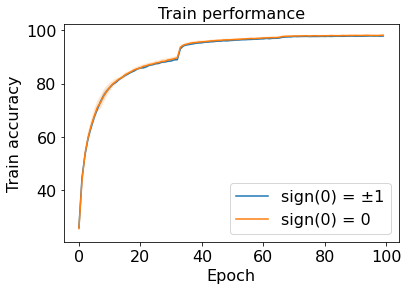

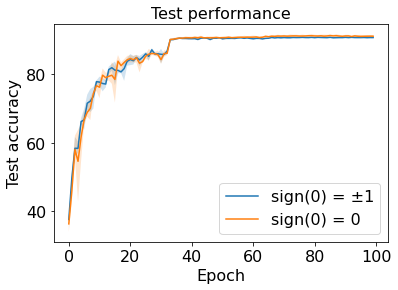

In [7]:

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=16)

for rand_zero in rand_list:
    acc_array = np.zeros((100, 3))
    for seed in seed_list:
        train_accs, test_accs = results[lr, rand_zero, seed]
        acc_array[:,seed] = train_accs
    mean = np.mean(acc_array, axis=1)
    min = np.min(acc_array, axis=1)
    max = np.max(acc_array, axis=1)
    label = "sign(0) = ±1" if rand_zero else "sign(0) = 0"
    plt.plot(mean, label=label)
    plt.fill_between(range(100), y1=min, y2=max, alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Train accuracy')
plt.title('Train performance')
plt.legend()
plt.show()

for rand_zero in rand_list:
    acc_array = np.zeros((100, 3))
    for seed in seed_list:
        train_accs, test_accs = results[lr, rand_zero, seed]
        acc_array[:,seed] = test_accs
    mean = np.mean(acc_array, axis=1)
    min = np.min(acc_array, axis=1)
    max = np.max(acc_array, axis=1)
    label = "sign(0) = ±1" if rand_zero else "sign(0) = 0"
    plt.plot(mean, label=label)
    plt.fill_between(range(100), y1=min, y2=max, alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.title('Test performance')
plt.legend()
plt.show()